# DeepSurv

This sub-repository contains the Python notebooks for the tutorial "Survival of the Fittest: Classical and Machine Learning Methods for Time-to-Event Modeling" of D. Meier and A. Sturge for the Data Science Working Group of the Swiss Actuarial Association, see https://actuarialdatascience.org.

Before running this notebook make sure that you have created all datasets by running the two notebooks "IPUMS NHIS Dataset" and "Synthetic Dataset".

In [3]:
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchtuples as tt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from torchtuples import optim as ttoptim
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored, integrated_brier_score
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from sklearn.metrics import log_loss
from sksurv.util import Surv
from scipy.special import logit
import time
import sys
import importlib

modules = [
    'polars',
    'pandas',
    'seaborn',
    'matplotlib',
    'numpy',
    'torch',
    'torchtuples',
    'pycox',
    'sksurv',
    'sklearn',
    'scipy'
]

print(f"Python version: {sys.version}\n")

for module in modules:
    try:
        mod = importlib.import_module(module)
        version = getattr(mod, '__version__', 'built-in or no __version__')
        print(f"{module} version: {version}")
    except ImportError:
        print(f"{module} is not installed.")

sns.set()

df = pl.read_csv("data/prepared_data.csv")
df = df.with_columns(pl.col("earnings_quantile").cast(pl.Float64))
df = df.with_columns(pl.col("HRSLEEP").cast(pl.Int64))

dfp = df.to_pandas()
dfp_nn = dfp.dropna()

Python version: 3.9.21 (main, Dec 11 2024, 10:23:52) 
[Clang 14.0.6 ]

polars version: 1.29.0
pandas version: 2.2.3
seaborn version: 0.13.2
matplotlib version: 3.9.2
numpy version: 1.26.4
torch version: 2.2.2
torchtuples version: 0.2.2
pycox version: 0.3.0
sksurv version: 0.23.1
sklearn version: 1.5.2
scipy version: 1.13.1


In [13]:
X = dfp_nn.drop(columns=["time", "event"])
T = dfp_nn["time"].to_numpy().astype('float32')
E = dfp_nn["event"].to_numpy().astype('bool')

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.to_numpy().astype('float32'))

X_train, X_test, T_train, T_test, E_train, E_test = train_test_split(X_scaled, T, E, test_size=0.2, random_state=0)
X_train, X_val, T_train, T_val, E_train, E_val = train_test_split(X_train, T_train, E_train, test_size=0.2, random_state=0)

np.random.seed(0)
torch.manual_seed(0)

in_features = X_train.shape[1]
net = torch.nn.Sequential(
    torch.nn.Linear(in_features, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Linear(32, 16),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(16),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(16, 1)
)
start_time = time.time()
model = CoxPH(net, ttoptim.Adam)
model.optimizer.set_lr(1e-3)
callbacks = [tt.callbacks.EarlyStopping(patience=20)]
model.fit(X_train, (T_train, E_train), batch_size=1024, epochs=100, verbose=True, val_data=(X_val, (T_val, E_val)), callbacks=callbacks)
model.compute_baseline_hazards()
print(f"Fitting time: {time.time() - start_time:.2f} seconds")
pred_surv = model.predict_surv_df(X_test)

0:	[0s / 0s],		train_loss: 6.1087,	val_loss: 7.7967
1:	[0s / 0s],		train_loss: 5.8607,	val_loss: 7.7687
2:	[0s / 1s],		train_loss: 5.8414,	val_loss: 7.7571
3:	[0s / 1s],		train_loss: 5.8355,	val_loss: 7.7546
4:	[0s / 1s],		train_loss: 5.8258,	val_loss: 7.7471
5:	[0s / 2s],		train_loss: 5.8192,	val_loss: 7.7466
6:	[0s / 2s],		train_loss: 5.8166,	val_loss: 7.7415
7:	[0s / 3s],		train_loss: 5.8114,	val_loss: 7.7445
8:	[0s / 3s],		train_loss: 5.8143,	val_loss: 7.7464
9:	[0s / 4s],		train_loss: 5.8077,	val_loss: 7.7346
10:	[0s / 5s],		train_loss: 5.8007,	val_loss: 7.7349
11:	[0s / 5s],		train_loss: 5.8003,	val_loss: 7.7367
12:	[0s / 5s],		train_loss: 5.7993,	val_loss: 7.7351
13:	[0s / 6s],		train_loss: 5.7976,	val_loss: 7.7296
14:	[0s / 6s],		train_loss: 5.7934,	val_loss: 7.7386
15:	[0s / 6s],		train_loss: 5.7915,	val_loss: 7.7324
16:	[0s / 7s],		train_loss: 5.7911,	val_loss: 7.7340
17:	[0s / 7s],		train_loss: 5.7953,	val_loss: 7.7328
18:	[0s / 8s],		train_loss: 5.7919,	val_loss: 7.7365
19:

C-index: 0.8711
Integrated Brier Score: 0.0393
Log loss for interval [2, 3): 0.0511


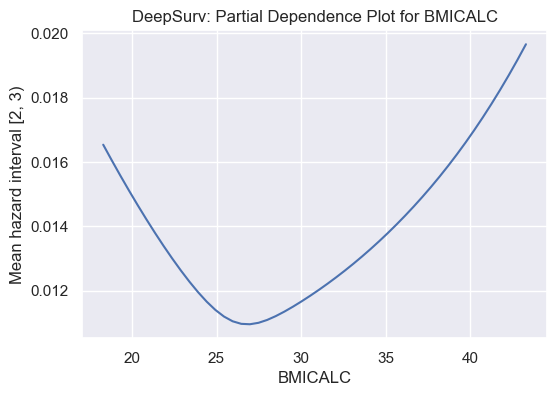

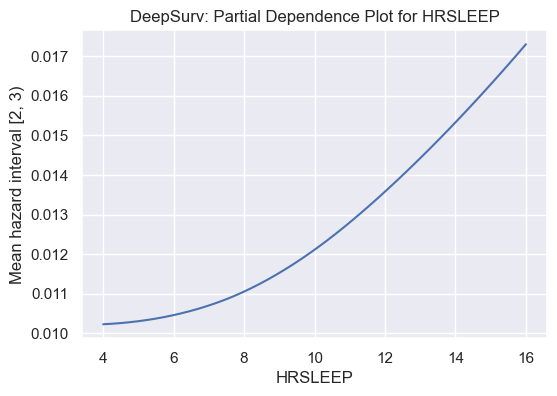

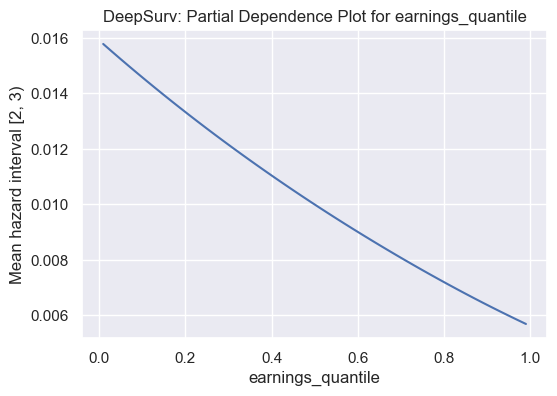

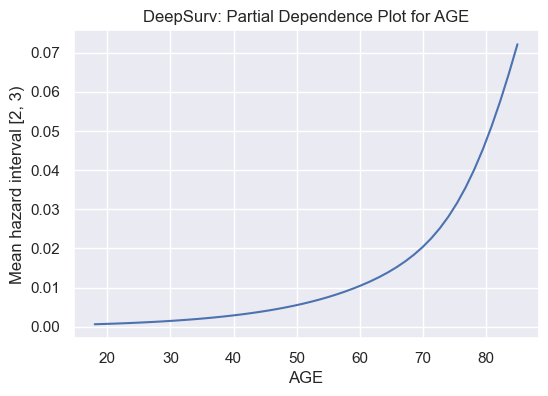

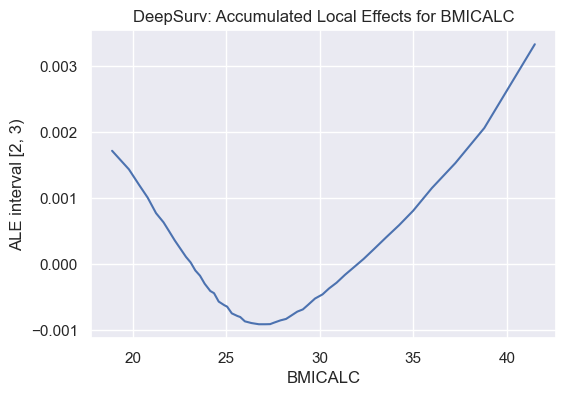

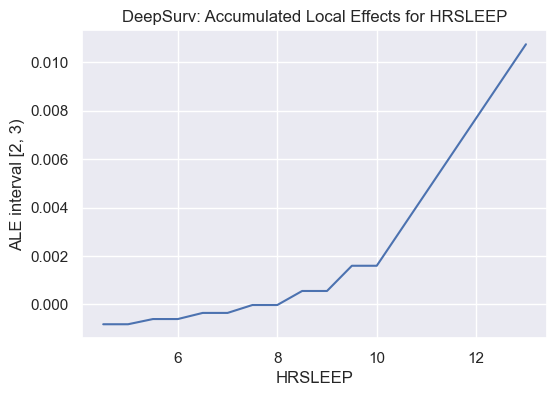

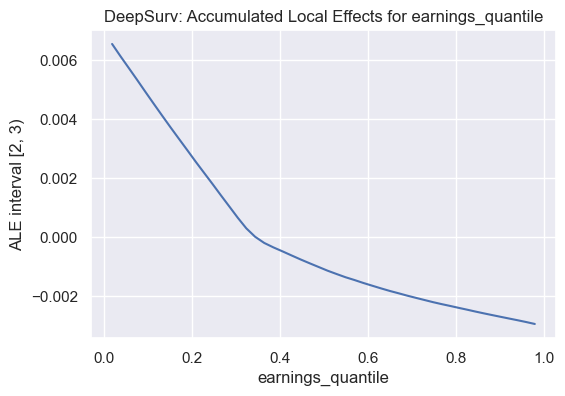

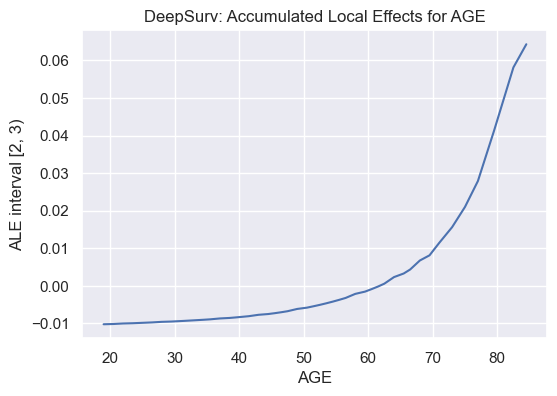

In [14]:
ev = EvalSurv(pred_surv, T_test, E_test, censor_surv='km')
c_index = ev.concordance_td('antolini')
print(f"C-index: {c_index:.4f}")

time_grid = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9.9])
ibs = ev.integrated_brier_score(time_grid)
print(f"Integrated Brier Score: {ibs:.4f}")

in_interval = ((E_test == True) & (T_test >= 2) & (T_test < 3)).astype(int)
p_interval = pred_surv.loc[2].values - pred_surv.loc[3].values
logloss = log_loss(in_interval, p_interval)
print(f"Log loss for interval [2, 3): {logloss:.4f}")

def plot_pdp(model, X_raw, X_scaled, variable, t1, t2):
    x_vals = np.linspace(X_raw[variable].quantile(0.01), X_raw[variable].quantile(0.99), 50)
    x_vals_scaled = np.linspace(0, 1, 50)
    y_vals = []

    for val in x_vals_scaled:
        X_copy = X_scaled.copy()
        X_copy[:, X_raw.columns.get_loc(var)] = val
        pred_surv = model.predict_surv_df(X_copy)
        y_vals.append(np.mean(pred_surv.loc[t1].values - pred_surv.loc[t2].values))

    plt.figure(figsize=(6, 4))
    plt.plot(x_vals, y_vals)
    plt.xlabel(variable)
    plt.ylabel(f"Mean hazard interval [{t1}, {t2})")
    plt.title(f"DeepSurv: Partial Dependence Plot for {variable}")
    plt.show()

def plot_ale(model, X_raw, X_scaled, variable, t1, t2):
    df = pd.DataFrame(data = X_scaled, columns = X_raw.columns)
    df_sorted = df.sort_values(by=variable)
    quantiles = np.linspace(0.01, 0.99, 51)
    bin_edges = df[variable].quantile(quantiles).values
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_edges_raw = X_raw[variable].quantile(quantiles).values
    bin_centers_raw = 0.5 * (bin_edges_raw[:-1] + bin_edges_raw[1:])
    
    ale_values = []
    for i in range(len(bin_edges) - 1):
        lower, upper = bin_edges[i], bin_edges[i+1]
        mask = (df[variable] >= lower) & (df[variable] < upper)
        df_bin = df[mask]
        
        if df_bin.empty:
            ale_values.append(0.0)
            continue
        
        df_low = df_bin.copy()
        df_high = df_bin.copy()
        df_low[variable] = lower
        df_high[variable] = upper

        pred_surv_high = model.predict_surv_df(df_high.to_numpy().astype('float32'))
        pred_surv_low = model.predict_surv_df(df_low.to_numpy().astype('float32'))
        pred_diff = (pred_surv_high.loc[t1].values - pred_surv_high.loc[t2].values) - (pred_surv_low.loc[t1].values - pred_surv_low.loc[t2].values)
        ale_values.append(np.mean(pred_diff))
    
    # Accumulate local effects
    ale_accumulated = np.cumsum(ale_values)
    ale_centered = ale_accumulated - np.mean(ale_accumulated)  # Centering
    
    plt.figure(figsize=(6, 4))
    plt.plot(bin_centers_raw, ale_centered)
    plt.xlabel(variable)
    plt.ylabel(f"ALE interval [{t1}, {t2})")
    plt.title(f"DeepSurv: Accumulated Local Effects for {variable}")
    plt.show()

for var in ['BMICALC', 'HRSLEEP', 'earnings_quantile', 'AGE']:
    plot_pdp(model, dfp_nn, X_scaled, var, 2, 3)

for var in ['BMICALC', 'HRSLEEP', 'earnings_quantile', 'AGE']:
    plot_ale(model, dfp_nn.drop(columns=["time", "event"]), X_scaled, var, 2, 3)

In [6]:
D2 = pd.read_csv("data/D2.csv")
D2["T"] = np.floor(D2["T"])

X_D2 = D2.drop(columns=["T", "event", "mu", "BMI_scaled", "SBP_scaled", "SD_SBP_scaled", "TCL_HDL_RATIO_scaled"])
T_D2 = D2["T"].to_numpy().astype('float32')
E_D2 = D2["event"].to_numpy().astype('bool')
mu_D2 = D2["mu"].to_numpy().astype('float32')

scaler = MinMaxScaler()
X_D2_scaled = scaler.fit_transform(X_D2.to_numpy().astype('float32'))

X_D2_train, X_D2_test, T_D2_train, T_D2_test, E_D2_train, E_D2_test, mu_D2_train, mu_D2_test = train_test_split(X_D2_scaled, T_D2, E_D2, mu_D2, test_size=0.2, random_state=0)
X_D2_train, X_D2_val, T_D2_train, T_D2_val, E_D2_train, E_D2_val = train_test_split(X_D2_train, T_D2_train, E_D2_train, test_size=0.2, random_state=0)

np.random.seed(0)
torch.manual_seed(0)

in_features = X_D2_train.shape[1]
net = torch.nn.Sequential(
    torch.nn.Linear(in_features, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Linear(32, 16),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(16),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(16, 1)
)
start_time = time.time()
model = CoxPH(net, ttoptim.Adam)
model.optimizer.set_lr(1e-3)
callbacks = [tt.callbacks.EarlyStopping(patience=20)]
model.fit(X_D2_train, (T_D2_train, E_D2_train), batch_size=1024, epochs=50, verbose=True, val_data=(X_D2_val, (T_D2_val, E_D2_val)), callbacks=callbacks)
model.compute_baseline_hazards()
print(f"Fitting time: {time.time() - start_time:.2f} seconds")
pred_surv = model.predict_surv_df(X_D2_test)

0:	[2s / 2s],		train_loss: 5.5337,	val_loss: 7.4246
1:	[2s / 4s],		train_loss: 5.3693,	val_loss: 7.3998
2:	[2s / 6s],		train_loss: 5.3322,	val_loss: 7.3817
3:	[2s / 8s],		train_loss: 5.3212,	val_loss: 7.3764
4:	[2s / 10s],		train_loss: 5.3121,	val_loss: 7.3684
5:	[2s / 12s],		train_loss: 5.3080,	val_loss: 7.3622
6:	[2s / 14s],		train_loss: 5.3057,	val_loss: 7.3666
7:	[2s / 17s],		train_loss: 5.3025,	val_loss: 7.3612
8:	[2s / 19s],		train_loss: 5.3011,	val_loss: 7.3559
9:	[2s / 21s],		train_loss: 5.2978,	val_loss: 7.3574
10:	[2s / 23s],		train_loss: 5.2950,	val_loss: 7.3539
11:	[2s / 25s],		train_loss: 5.2940,	val_loss: 7.3524
12:	[2s / 28s],		train_loss: 5.2941,	val_loss: 7.3553
13:	[2s / 30s],		train_loss: 5.2933,	val_loss: 7.3506
14:	[2s / 32s],		train_loss: 5.2897,	val_loss: 7.3501
15:	[2s / 34s],		train_loss: 5.2913,	val_loss: 7.3504
16:	[2s / 37s],		train_loss: 5.2919,	val_loss: 7.3472
17:	[2s / 39s],		train_loss: 5.2885,	val_loss: 7.3527
18:	[2s / 41s],		train_loss: 5.2885,	val_l

In [7]:
pred = np.minimum(1-1e-10, 1 - pred_surv.loc[10].values)
mse = np.mean(np.square(np.log(mu_D2_test) - np.log(pred)))
dev = -2*np.sum(E_D2_test*logit(pred) + np.log(1-pred))
kld = -np.sum(np.log(pred[E_D2_test==1]))
print(f"MSE wrt log ground truth:    {mse:.4f}")
print(f"Logistic deviance:           {dev:.0f}")
print(f"Kullback-Leibler divergence: {kld:.0f}")

MSE wrt log ground truth:    0.1033
Logistic deviance:           101591
Kullback-Leibler divergence: 33739


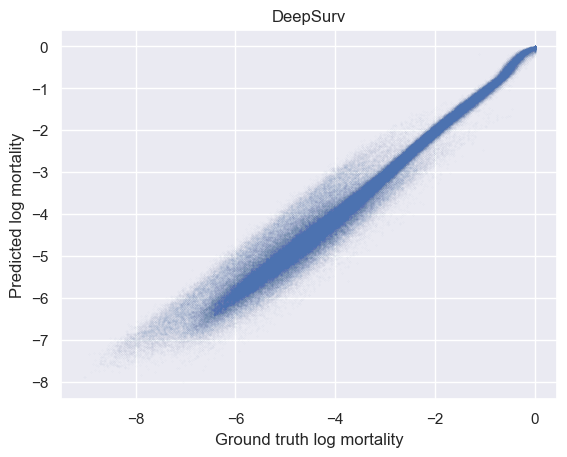

In [8]:
plt.plot(np.log(mu_D2_test), np.log(pred), '.', alpha=0.1, markersize=0.25)
plt.title("DeepSurv")
plt.xlabel("Ground truth log mortality")
plt.ylabel("Predicted log mortality")
plt.show()

In [9]:
ev = EvalSurv(pred_surv, T_D2_test, E_D2_test, censor_surv='km')
c_index = ev.concordance_td('antolini')
print(f"C-index: {c_index:.4f}")

time_grid = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9.9])
ibs = ev.integrated_brier_score(time_grid)
print(f"Integrated Brier Score: {ibs:.4f}")

in_interval = (E_D2_test == True).astype(int)
p_interval = 1 - pred_surv.loc[10].values
logloss = log_loss(in_interval, p_interval)
print(f"Log loss for interval [0, 10): {logloss:.4f}")

C-index: 0.9072
Integrated Brier Score: 0.0352
Log loss for interval [0, 10): 0.1845


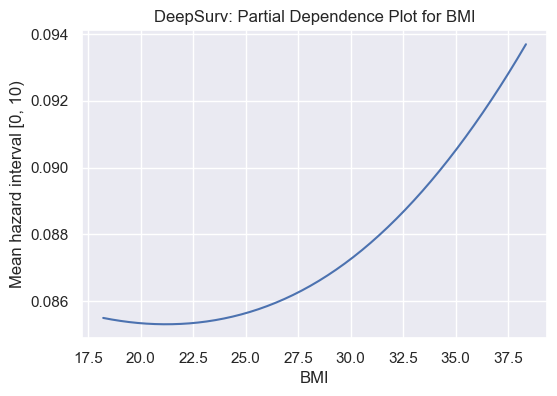

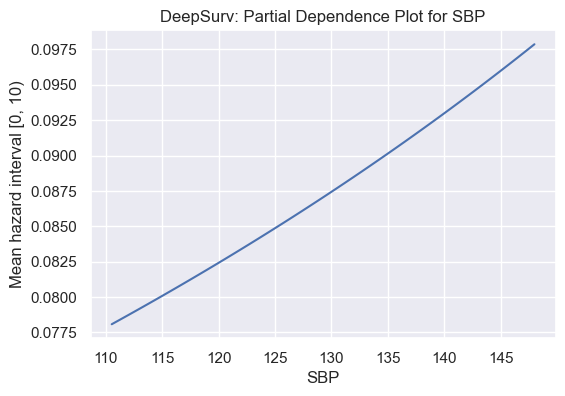

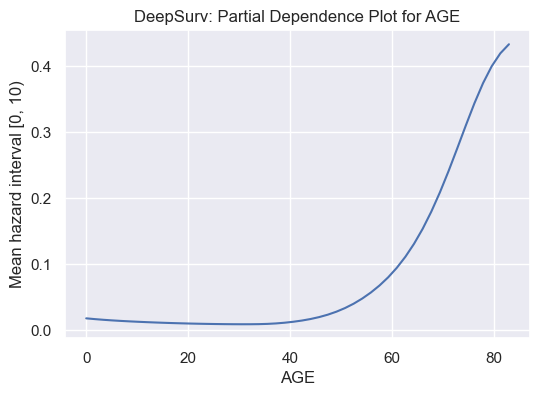

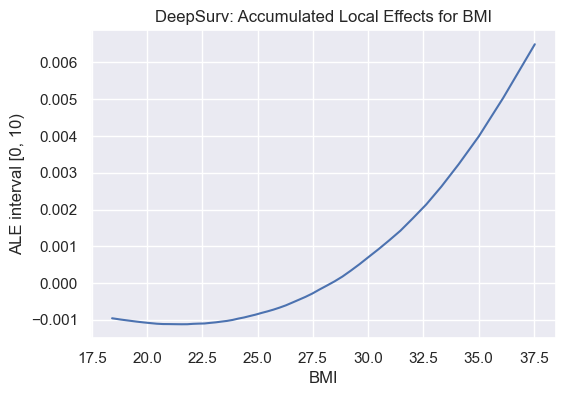

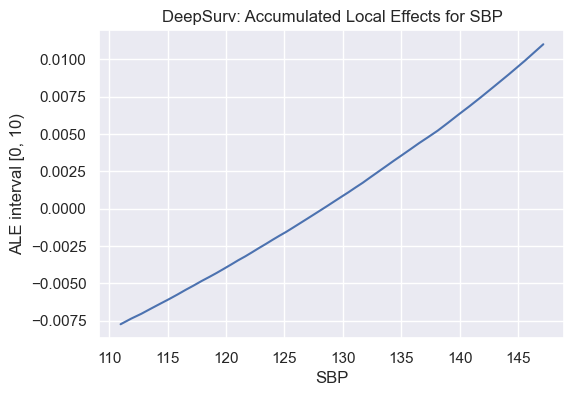

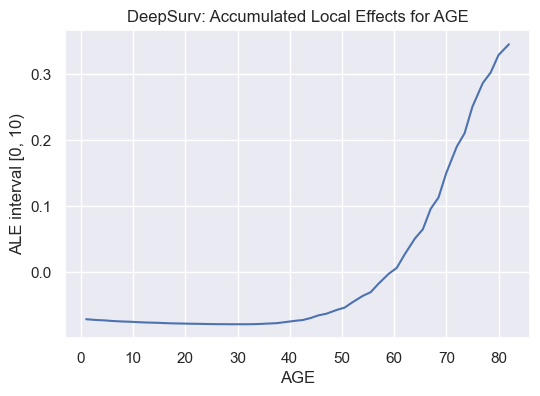

In [10]:
for var in ["BMI", "SBP", "AGE"]:
    plot_pdp(model, X_D2, X_D2_test, var, 0, 10)

for var in ["BMI", "SBP", "AGE"]:
    plot_ale(model, X_D2, X_D2_test, var, 0, 10)